<a href="https://colab.research.google.com/github/igvasilev/study-projects/blob/master/Autoencoders_classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Optimal classification using latent space generated from Autoencoders**

#### Import libs

In [ ]:
# install tf 2.0
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 38.1MB/s 
     |████████████████████████████████| 450kB 44.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=120830eba0eda2855d94d95ca61a29c5f0ad45c75376b379a2e56cc4e284ce7a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1

In [ ]:
import datetime, os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from tensorflow.keras import datasets
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.optimizers import adam

from tensorflow.python.framework import ops

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
print(tf.__version__)

2.0.0


#### Downloading and preprocessing

In [ ]:
mnist = datasets.mnist

(train_images, y_train), (test_images, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# add a channel dimension to every image in the dataset, then scale images to [0, 1]
X_train = np.expand_dims(train_images, axis=-1)
X_test = np.expand_dims(test_images, axis=-1)
# center images
X_train = X_train.astype("float32") / 255.0 
X_test = X_test.astype("float32") / 255.0 

#### show img

In [ ]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)


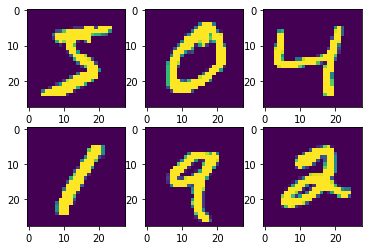

In [ ]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X_train[i].reshape((28, 28)))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



#### One hot

In [ ]:
y_train[0]

5

In [ ]:
# one-hot encode the target
y_train_oh = to_categorical(y_train, 10)
y_test_oh = to_categorical(y_test, 10)

print("y_train_oh shape:", y_train_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)
y_train_oh[0]

y_train_oh shape: (60000, 10)
y_test_oh shape: (10000, 10)


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

#### Build autoencoder

Our encoder and decoder parts consist of 4 layers blocks and pooling layers with batch normalization after it. Some layers can be excluded.

For encoder part:

**Convolutional block**
*   Convolution layer 
*   LeakyReLu activation
*   Dropout layer

**MaxPooling block**
* MaxPooling layer
* BatchNormalization layer

for decoder part:

**Deconvolutional block**
*   Conv2DTranspose layer 
*  LeakyReLu activation
*   Dropout layer

**UpSampling block**
*   UpSampling2D layer
* BatchNormalization layer

We try several architectures with 1, 2 and 3 Pooling layers as we can`t use more because of the size of our images.

Before each Pooling layer we will stack the same number of convolutional/deconvolutional layers

In [ ]:
# The code based on the source: 
# https://blog.keras.io/building-autoencoders-in-keras.html

def conv_block(x, f, k=(3, 3), s=1, a=0.1, drop_rate=0.25, pad="valid", encoder=True):
    # encoder
    if encoder:
        x = Conv2D(filters=f, kernel_size=k, strides=s, activation='elu', padding=pad)(x)
        #x = LeakyReLU(alpha=a)(x)
        x = Dropout(drop_rate)(x)
    # decoder
    else:
        x = Conv2DTranspose(filters=f, kernel_size=k, strides=s, activation='elu', padding=pad)(x)
        #x = LeakyReLU(alpha=a)(x)
        x = Dropout(drop_rate)(x)   
    return x



def pooling_block(x, pool = (2, 2), pad="valid", encoder=True):
    # encoder
    if encoder:
        x = MaxPooling2D(pool, padding=pad)(x)
        x = BatchNormalization(axis=-1)(x)
    # decoder
    else:
        x = UpSampling2D(pool)(x)
        x = BatchNormalization(axis=-1)(x)
    return x


def get_autoencoder(X, latDim):
    # reset tf session 
    tf.keras.backend.clear_session()

    # hyperparams 
    _latentDim=latDim

    # define the network
    (height, width, depth) = X.shape[1:]
    inputShape = (height, width, depth)
    inputs = Input(shape=inputShape)
    x = inputs

    # encoder

    x = enc(x)

    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(_latentDim)(x)
    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latentInputs = Input(shape=(_latentDim,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

    # decoder
    
    x = dec(x)

    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")
    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    return encoder, decoder, autoencoder



#### CP

In [ ]:
# CP
# https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e
def enc(x):
    x = conv_block(x, f=32, k=(5,5), pad='same')
    x = pooling_block(x)

    return x
    

def dec(x):
    x = conv_block(x, f=32, k=(5,5), encoder=False, pad='same')
    x = pooling_block(x, encoder=False)

    return x


In [ ]:
encoder, decoder, autoencoder = get_autoencoder(X_train, 16)

In [ ]:
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                1003

In [ ]:
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              106624    
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        25632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128 

In [ ]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                101328    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         132673    
Total params: 234,001
Trainable params: 233,873
Non-trainable params: 128
_________________________________________________________________
None


In [ ]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer='adam', loss="mse")

# Load the TensorBoard notebook extension
%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from keras.callbacks import TensorBoard

history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[tensorboard_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 235s 4ms/sample - loss: 0.0311 - val_loss: 0.0176
Epoch 2/10
60000/60000 [==============================] - 227s 4ms/sample - loss: 0.0151 - val_loss: 0.0146
Epoch 3/10
60000/60000 [==============================] - 224s 4ms/sample - loss: 0.0140 - val_loss: 0.0140
Epoch 4/10
60000/60000 [==============================] - 224s 4ms/sample - loss: 0.0135 - val_loss: 0.0151
Epoch 5/10
60000/60000 [==============================] - 224s 4ms/sample - loss: 0.0132 - val_loss: 0.0139
Epoch 6/10
60000/60000 [==============================] - 223s 4ms/sample - loss: 0.0130 - val_loss: 0.0137
Epoch 7/10
60000/60000 [==============================] - 230s 4ms/sample - loss: 0.0128 - val_loss: 0.0138
Epoch 8/10
60000/60000 [==============================] - 230s 4ms/sample - loss: 0.0127 - val_loss: 0.0139
Epoch 9/10
60000/60000 [==============================] - 232s 4ms/sample - loss: 0.01

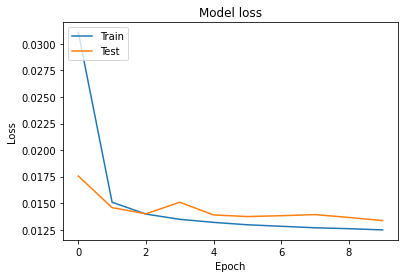

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# save trained weights
encoder.save_weights("encoderCP32.h5")
decoder.save_weights("decoderCP32.h5")

In [ ]:
encoder.load_weights("encoderCP32.h5")
decoder.load_weights("decoderCP32.h5")

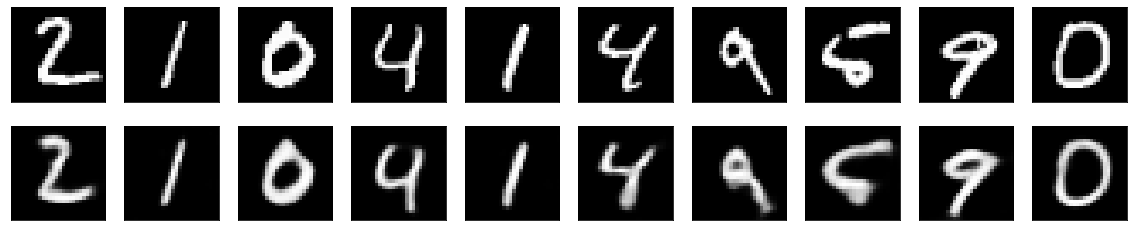

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)%alias_magi
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Next we will try the following architecture:
#### CCCP

In [ ]:

def enc(x):
    x = conv_block(x, f=32, k=(5,5), pad='same')
    x = conv_block(x, f=16, pad='same')
    x = conv_block(x, f=16, pad='same')
    x = pooling_block(x)

    return x
    

def dec(x):
    x = pooling_block(x, encoder=False)
    x = conv_block(x, f=16, encoder=False, pad='same')
    x = conv_block(x, f=16, encoder=False, pad='same')
    x = conv_block(x, f=32, k=(5,5), encoder=False, pad='same')

    return x


In [ ]:
encoder, decoder, autoencoder = get_autoencoder(X_train, 16)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 16)        0   

In [ ]:

autoencoder.compile(optimizer='adam', loss="mse")
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[tensorboard_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 638s 11ms/sample - loss: 0.0205 - val_loss: 0.0124
Epoch 2/10
60000/60000 [==============================] - 631s 11ms/sample - loss: 0.0128 - val_loss: 0.0129
Epoch 3/10
60000/60000 [==============================] - 642s 11ms/sample - loss: 0.0115 - val_loss: 0.0130
Epoch 4/10
60000/60000 [==============================] - 643s 11ms/sample - loss: 0.0107 - val_loss: 0.0121
Epoch 5/10
60000/60000 [==============================] - 636s 11ms/sample - loss: 0.0103 - val_loss: 0.0123
Epoch 6/10
60000/60000 [==============================] - 638s 11ms/sample - loss: 0.0100 - val_loss: 0.0117
Epoch 7/10
60000/60000 [==============================] - 634s 11ms/sample - loss: 0.0098 - val_loss: 0.0126
Epoch 8/10
60000/60000 [==============================] - 637s 11ms/sample - loss: 0.0096 - val_loss: 0.0109
Epoch 9/10
60000/60000 [==============================] - 639s 11ms/sample - l

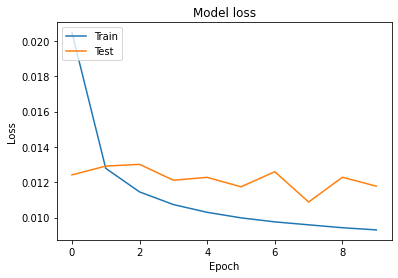

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# save trained weights
encoder.save_weights("encoderCCCP.h5")
decoder.save_weights("decoderCCCP.h5")

#### CCCCCP

In [ ]:
!nvidia-smi

In [ ]:

def enc(x):
    x = conv_block(x, f=32, k=(5,5), pad='same')
    x = conv_block(x, f=32, pad='same')
    x = conv_block(x, f=16, pad='same')
    x = conv_block(x, f=16, pad='same')
    x = conv_block(x, f=16, pad='same')
    x = pooling_block(x)

    return x
    

def dec(x):
    x = pooling_block(x, encoder=False)
    x = conv_block(x, f=16, encoder=False, pad='same')
    x = conv_block(x, f=16, encoder=False, pad='same')
    x = conv_block(x, f=16, encoder=False, pad='same')
    x = conv_block(x, f=32, encoder=False, pad='same')
    x = conv_block(x, f=32, k=(5,5), encoder=False, pad='same')

    return x


encoder, decoder, autoencoder = get_autoencoder(X_train, 16)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 16)        0   

#### train

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = 'c5p.{epoch:02d}-{val_loss:.2f}.hdf5' 
checkpoint_callback = ModelCheckpoint(filepath, 
                                          monitor='val_loss', 
                                          verbose=0, 
                                          save_best_only=False, 
                                          save_weights_only=False, 
                                          mode='auto', 
                                          period=1)

autoencoder.compile(optimizer='adam', loss="mse")
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpoint_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 914s 15ms/sample - loss: 0.0211 - val_loss: 0.0180
Epoch 2/10
60000/60000 [==============================] - 934s 16ms/sample - loss: 0.0129 - val_loss: 0.0165
Epoch 3/10
60000/60000 [==============================] - 958s 16ms/sample - loss: 0.0115 - val_loss: 0.0128
Epoch 4/10
60000/60000 [==============================] - 941s 16ms/sample - loss: 0.0108 - val_loss: 0.0101
Epoch 5/10
60000/60000 [==============================] - 949s 16ms/sample - loss: 0.0103 - val_loss: 0.0091
Epoch 6/10
60000/60000 [==============================] - 908s 15ms/sample - loss: 0.0099 - val_loss: 0.0125
Epoch 7/10
60000/60000 [==============================] - 882s 15ms/sample - loss: 0.0097 - val_loss: 0.0095
Epoch 8/10
60000/60000 [==============================] - 874s 15ms/sample - loss: 0.0095 - val_loss: 0.0117
Epoch 9/10
60000/60000 [==============================] - 878s 15ms/sample - l

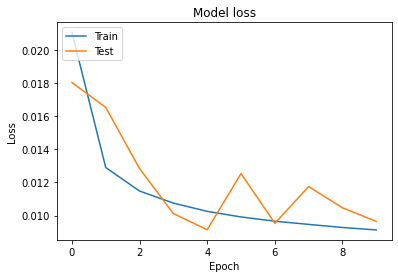

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# save trained weights
encoder.save_weights("encoderC5Pn.h5")
decoder.save_weights("decoderC5Pn.h5")

In [ ]:
history.history['loss']

[0.021051022423803807,
 0.012896086039642493,
 0.011479641603430112,
 0.010753178441524505,
 0.010253456122179826,
 0.009916977054377397,
 0.009661606386800607,
 0.00946804311722517,
 0.00928199070096016,
 0.009135228453079859]

In [ ]:
history.history['val_loss']

[0.01801843265593052,
 0.01652120060324669,
 0.012833324824273587,
 0.010120439016819,
 0.009145584054291249,
 0.012532455909252166,
 0.009534376600384711,
 0.011747875946760177,
 0.010471012397110463,
 0.009646200849115848]

#### load

In [ ]:
encoder.load_weights("encoderC5Pn.h5")
decoder.load_weights("decoderC5Pn.h5")

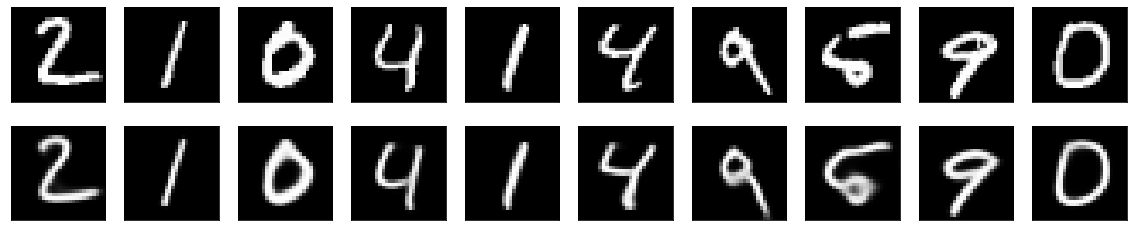

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n=0
for layer in encoder.layers:
    print('idx:', n, 'layer:', layer)
    n += 1

idx: 0 layer: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f01f8d0bc18>
idx: 1 layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01e80149e8>
idx: 2 layer: <tensorflow.python.keras.layers.core.Dropout object at 0x7f0216efa400>
idx: 3 layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01e77df4a8>
idx: 4 layer: <tensorflow.python.keras.layers.core.Dropout object at 0x7f01dff9abe0>
idx: 5 layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01dff9a358>
idx: 6 layer: <tensorflow.python.keras.layers.core.Dropout object at 0x7f01dff60fd0>
idx: 7 layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01dff60e48>
idx: 8 layer: <tensorflow.python.keras.layers.core.Dropout object at 0x7f01dfebc748>
idx: 9 layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01dff20c50>
idx: 10 layer: <tensorflow.python.keras.layers.core.Dropout object at 0x7f01dfe7ccc0>
idx: 11 layer:

In [ ]:
# input, conv1, conv2, conv3, conv4, conv5, flatten and dense(16) - bottleneck
#n_layers = [0, 1, 3, 5, 7, 9, 13, 14]
#layers = []
#for i in n_layers:
    #layers.append(encoder.layers[i])

#UPD: As it doesn`t suits into memory, I choose to take only 4-5 representative layers:
#
#UPD: This number of layers also has crushed Colab, reduce to 3-4
n_layers = [0, 7, 13, 14]
layers = []
for i in n_layers:
    layers.append(encoder.layers[i])


In [ ]:
# k.learning_phase() raise an error in tf2.0, so this import fix this problem
from tensorflow.python.keras import backend as K

inp = encoder.input                                           # input placeholder
outputs = [Flatten()(layer.output) for layer in layers]          # all layer outputs
functor = K.function([inp, K.symbolic_learning_phase()], outputs)   # evaluation function


# Train
train = X_train
X_train_list = functor([train, False])

# Testing
test = X_test
# To simulate Dropout use learning_phase as 1. in layer_outs otherwise use 0.
X_test_list = functor([test, False])

In [ ]:

def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):
    # Fit all estimators with their respective feature arrays
    estimators_ = [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]
    return estimators_ 


def predict_from_multiple_estimator(estimators, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)

    return pred

#### Logistic regression

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.linear_model import LogisticRegression

#check execution time
start_time = time.clock()
# Make sure the number of estimators here are equal to number of different feature datas
classifiers = [('lr1', LogisticRegression()),
               ('lr2', LogisticRegression()),
               ('lr3', LogisticRegression()),
               ('lr4', LogisticRegression())]

fitted_estimators = fit_multiple_estimators(classifiers, X_train_list, y_train)
y_pred = predict_from_multiple_estimator(fitted_estimators, X_test_list)
print(time.clock() - start_time, "seconds")

ERROR! Session/line number was not unique in database. History logging moved to new session 59


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


3573.8871470000004 seconds


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9861


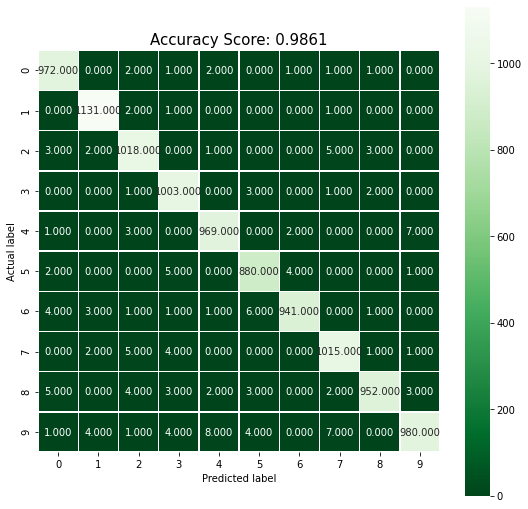

In [ ]:
import seaborn as sns
from sklearn import metrics
score = accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

#### Now, compare it with classification on the initial data

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_tr=np.array(list(map(lambda x: x.reshape((-1, )), X_train)))
X_te=np.array(list(map(lambda x: x.reshape((-1, )), X_test)))

In [ ]:
X_te.shape

(10000, 784)

In [ ]:
clf=LogisticRegression()
clf.fit(X_tr, y_train)
y_pred1=clf.predict(X_te)
print(accuracy_score(y_test, y_pred1))

0.9256


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
score1 = accuracy_score(y_test, y_pred1)
cm = metrics.confusion_matrix(y_test, y_pred1)
print('Accuracy Score: {0}'.format(score1))
print()
print('Confusion matrix')
print(cm)

Accuracy Score: 0.9256

Confusion matrix
[[ 959    0    0    3    1    7    5    4    1    0]
 [   0 1112    4    2    0    2    3    2   10    0]
 [   6    9  928   16    8    4   15    7   35    4]
 [   4    1   17  921    0   23    4   11   23    6]
 [   1    1    7    4  914    0   10    4   10   31]
 [  10    2    3   37    8  779   14    5   29    5]
 [   9    3    7    3    8   15  910    2    1    0]
 [   1    9   23    6    7    1    0  950    2   29]
 [   9   10    8   26    8   26   12    7  857   11]
 [   9    8    0   11   23    6    0   19    7  926]]


#### Classification KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import time
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#check execution time
start_time = time.clock()
# Make sure the number of estimators here are equal to number of different feature datas
classifiers = [('knn1', KNeighborsClassifier()),
               ('knn2', KNeighborsClassifier()),
               ('knn3', KNeighborsClassifier()),
               ('knn4', KNeighborsClassifier())]

fitted_estimators = fit_multiple_estimators(classifiers, X_train_list, y_train)
y_pred = predict_from_multiple_estimator(fitted_estimators, X_test_list)
print(time.clock() - start_time, "seconds")
print()
print(accuracy_score(y_test, y_pred))

15441.563836 seconds

0.9804


In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 975,    1,    1,    0,    0,    1,    1,    1,    0,    0],
       [   0, 1131,    2,    0,    0,    0,    1,    0,    0,    1],
       [   7,    1, 1005,    2,    1,    0,    1,   10,    5,    0],
       [   0,    0,    1,  988,    1,    5,    0,    4,    6,    5],
       [   1,    0,    0,    0,  958,    0,    5,    1,    1,   16],
       [   3,    0,    0,    8,    2,  869,    6,    1,    1,    2],
       [   2,    3,    0,    0,    0,    1,  950,    0,    2,    0],
       [   1,    7,    3,    0,    4,    0,    0, 1002,    0,   11],
       [   3,    0,    1,    9,    3,    3,    2,    3,  946,    4],
       [   3,    4,    0,    8,    2,    3,    0,    6,    3,  980]])

In [ ]:
# baseline
X_tr=np.array(list(map(lambda x: x.reshape((-1, )), X_train)))
X_te=np.array(list(map(lambda x: x.reshape((-1, )), X_test)))



In [ ]:
start_time = time.clock()
clf = KNeighborsClassifier()
clf.fit(X_tr, y_train)
y_predKNN = clf.predict(X_te)
print(time.clock() - start_time, "seconds")
print()
print(accuracy_score(y_test, y_predKNN))

820.7202450000004 seconds

0.9688


In [ ]:
# CODE
start_time = time.clock()
clf = KNeighborsClassifier()
clf.fit(X_train_list[3], y_train)
y_predKNNCode = clf.predict(X_test_list[3])
print(time.clock() - start_time, "seconds")
print()
print(accuracy_score(y_test, y_predKNNCode))

5.762569999998959 seconds

0.9731
